# Interpolation of a vector field on the cubed-sphere
This notebook shows how to interpolate a vector field defined on a cubed-sphere onto a regular lon-lat grid. 

In [1]:
import mint
import numpy

## Load the grid from the Ugrid file

In [2]:
# the Ugrid file containing the grid and the wind velocities
src_filename = '../../data/lfric_diag_wind.nc'
src_meshname = 'Mesh2d'

# instantiate the grid object
src_grid = mint.Grid()

# these flags are required for rectilinear grids
src_grid.setFlags(fixLonAcrossDateline=1, averageLonAtPole=1)

# load the grid form the Ugrid file. Note we need to specify 
# the mesh name as well since the Ugrid file may contain several
# grids
src_grid.loadFromUgrid2D(src_filename + '$' + src_meshname)

# it's good practice to check that the grid object is valid,
# we don't want butterfly cells
num_bad_cells = src_grid.check()
print(f'num bad cells = {num_bad_cells}')

num bad cells = 0


## Read the wind components
LFRic stores the wind compomponents on edges of the 2d horizontal grid. 

In [3]:
import netCDF4
# get the velocities
nc = netCDF4.Dataset(src_filename)

# eastward wind
u1 = nc.variables['u1'][:]
# northward wind
u2 = nc.variables['u2'][:]

# longitudes and latitudes at cell vertices
lon = nc.variables['Mesh2d_node_x']
lat = nc.variables['Mesh2d_node_y']

# edge to node connectivity
edge_node_connect = nc.variables['Mesh2d_edge_nodes']

## Compute the edge/face integrals of the vector field
This can be done either in lon-lat or in Cartesian coordinates

In [4]:
earth_radius = 6371e3

def getEdgeIntegralsInLonLat(lon, lat, edge_node_connect, u1, u2, edge=True):
    nedge = edge_node_connect.shape[0]
    # start node indices for each edge
    ibeg = edge_node_connect[:, 0]
    # end node indices for each edge
    iend = edge_node_connect[:, 1]
    # edge lengths of the edges in lon-lat
    ds = numpy.zeros((nedge, 2), numpy.float64)
    dlon = lon[iend] - lon[ibeg]
    # add/subtract a periodicity length to account for the multivaluedness
    # of the lon coordinate
    adlon = numpy.fabs(dlon)
    adlonMns = numpy.fabs(dlon - 360.)
    adlonPls = numpy.fabs(dlon + 360.)
    iMns = numpy.where(adlonMns < adlon)
    iPls = numpy.where(adlonPls < adlon)
    ds[:, 0] = dlon
    ds[iMns, 0] = dlon[iMns] - 360.
    ds[iPls, 0] = dlon[iPls] + 360.
    ds[:, 1] = lat[iend] - lat[ibeg]
    # convert ds to metres
    ds *= earth_radius * numpy.pi / 180.
    if edge:
        return u1[:]*ds[:, 0] + u2[:]*ds[:, 1]
    else:
        return u1[:]*ds[:, 1] - u2[:]*ds[:, 1]

def getIntegralsInXYZ(lon, lat, edge_node_connect, u1, u2, edge=True):
    nedge = edge_node_connect.shape[0]
    # start node indices for each edge
    ibeg = edge_node_connect[:, 0]
    # end node indices for each edge
    iend = edge_node_connect[:, 1]
    
    lonbeg = lon[ibeg]
    lonend = lon[iend]
    lonmid = (lonbeg + lonend)*0.5

    latbeg = lat[ibeg]
    latend = lat[iend]
    latmid = (latbeg + latend)*0.5

    deg2rad = numpy.pi/180.

    rho = earth_radius * numpy.cos(latbeg*deg2rad)
    xyzbeg = numpy.zeros((nedge, 3), numpy.float64)
    xyzbeg[:, 0] = rho * numpy.cos(lonbeg*deg2rad)
    xyzbeg[:, 1] = rho * numpy.sin(lonbeg*deg2rad)
    xyzbeg[:, 2] = earth_radius * numpy.sin(latbeg*deg2rad)
    
    rho = earth_radius * numpy.cos(latend*deg2rad)
    xyzend = numpy.zeros((nedge, 3), numpy.float64)
    xyzend[:, 0] = rho * numpy.cos(lonend*deg2rad)
    xyzend[:, 1] = rho * numpy.sin(lonend*deg2rad)
    xyzend[:, 2] = earth_radius * numpy.sin(latend*deg2rad)

    ds = xyzend - xyzbeg

    # unit vectors at the mid edge point
    lambda_hat = numpy.zeros((nedge, 3), numpy.float64)
    lambda_hat[:, 0] = - numpy.sin(lonmid*deg2rad)
    lambda_hat[:, 1] = numpy.cos(lonmid*deg2rad)

    theta_hat = numpy.zeros((nedge, 3), numpy.float64)
    theta_hat[:, 0] = - numpy.sin(latmid*deg2rad) * numpy.cos(lonmid*deg2rad)
    theta_hat[:, 1] = - numpy.sin(latmid*deg2rad) * numpy.sin(lonmid*deg2rad)
    theta_hat[:, 2] = numpy.cos(latmid*deg2rad)
    
    if edge:
        return u1*numpy.sum(lambda_hat*ds, axis=1) + u2*numpy.sum(theta_hat*ds, axis=1)
    else:
        return u1*numpy.sum(theta_hat*ds, axis=1) - u2*numpy.sum(lambda_hat*ds, axis=1)

In [5]:
ue_integrated_lonlat = getEdgeIntegralsInLonLat(lon, lat, edge_node_connect, u1[0,0,:], u2[0,0,:])
ue_integrated_xyz = getEdgeIntegralsInXYZ(lon, lat, edge_node_connect, u1[0,0,:], u2[0,0,:])

In [6]:
# create target grid
llon, llat = numpy.meshgrid(numpy.linspace(-180., 180., 40), numpy.linspace(-80., 80., 20))
ntarget = llon.shape[0] * llon.shape[1]
target_points = numpy.zeros((ntarget, 3), numpy.float64)
target_points[:, 0] = llon.flat
target_points[:, 1] = llat.flat

In [7]:
# create a vector interpolator
vi = mint.VectorInterp()
vi.setGrid(src_grid)
vi.buildLocator(numCellsPerBucket=10)
vi.findPoints(target_points, tol2=1.e-10)
# placement = 1 means data use a unique edge placement
edgeVectors_lonlat = vi.getEdgeVectors(ue_integrated_lonlat, placement=1)
edgeVectors_xyz = vi.getEdgeVectors(ue_integrated_xyz, placement=1)

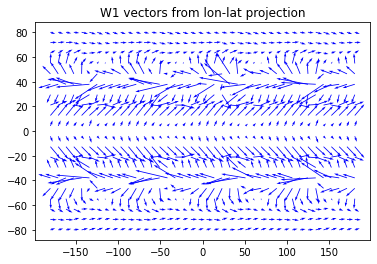

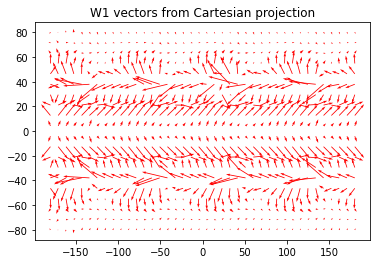

In [8]:
from matplotlib import pylab
pylab.quiver(target_points[:, 0], target_points[:, 1], edgeVectors_lonlat[:, 0], edgeVectors_lonlat[:, 1], color='b', scale=500000)
pylab.title('W1 vectors from lon-lat projection')
pylab.show()

pylab.quiver(target_points[:, 0], target_points[:, 1], edgeVectors_xyz[:, 0], edgeVectors_xyz[:, 1], color='r', scale=500000)
pylab.title('W1 vectors from Cartesian projection')
pylab.show()